**Урок 4. Сверточные нейронные сети**

ДЗ - поиграться с кодом соревнования по Северстали, получить как можно лучший результат.

Альтернативное ДЗ - рассмотреть постановку и решение аналогичного индустриального кейса.

Сдавать как обычно блокнот через Гитхаб или Гугл колаб.


Сталь – один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместно распространенным во всем мире. Чтобы сделать производство стали более эффективным, этот конкурс поможет выявить дефекты.


ссылка на каггл с этим соревнованием - https://www.kaggle.com/c/severstal-steel-defect-detection

### Постановка задачи :

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

**Загрузка датасета**

In [11]:
data = pd.read_csv('/home/train.csv')

In [12]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [13]:
data.shape

(7095, 3)

# Разведочный анализ данных

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

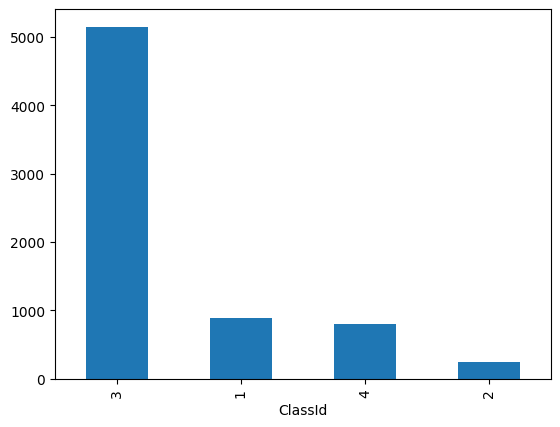

In [14]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

больше всего меток третьего класса

Перекос данных, поэтому выполним аугментацию.

In [15]:
import cv2

**Загружаем фото из zip-архива**

In [16]:
!unzip "/home/train_images.zip" -d "train_images"

Archive:  /home/train_images.zip
replace train_images/f00185797.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace train_images/f00185797.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train_images/f00185797.jpg  
  inflating: train_images/f0074b888.jpg  
  inflating: train_images/f0075e43c.jpg  
  inflating: train_images/f024c4789.jpg  
  inflating: train_images/f03379160.jpg  
  inflating: train_images/f0344b3ad.jpg  
  inflating: train_images/f035b1e71.jpg  
  inflating: train_images/f0437a9c3.jpg  
  inflating: train_images/f046dc5fa.jpg  
  inflating: train_images/f061c7c53.jpg  
  inflating: train_images/f0625054e.jpg  
  inflating: train_images/f07399cf6.jpg  
  inflating: train_images/f07969848.jpg  
  inflating: train_images/f0859ea87.jpg  
  inflating: train_images/f08716423.jpg  
  inflating: train_images/f10768627.jpg  
  inflating: train_images/f10e66f64.jpg  
  inflating: train_images/f10f625fd.jpg  
  inflating: train_images/f111

**Делаем преобразование фотографий к формату 120х120**

In [17]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    try:
      image=cv2.imread("train_images/{}".format(img),cv2.IMREAD_COLOR)
      image = cv2.resize(image,(120,120))
      l1.append(image)
      l2.append(ClassId)
    except:
      continue





100%|██████████| 7095/7095 [00:04<00:00, 1573.77it/s]


array([[[  2,   2,   2],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [ 74,  74,  74],
        [ 60,  60,  60],
        [ 64,  64,  64]],

       [[  2,   2,   2],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [ 73,  73,  73],
        [ 66,  66,  66],
        [ 65,  65,  65]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [ 75,  75,  75],
        [ 65,  65,  65],
        [ 61,  61,  61]],

       ...,

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [114, 114, 114],
        [114, 114, 114],
        [105, 105, 105]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [112, 112, 112],
        [109, 109, 109],
        [108, 108, 108]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [117, 117, 117],
        [109, 109, 109],
        [109, 109, 109]]], dtype=uint8)
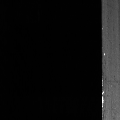

In [18]:
l1[0]

In [19]:
len(l1)

351

Проверка изображений случайной стали, чтобы проверить, дефектна ли она или нет.

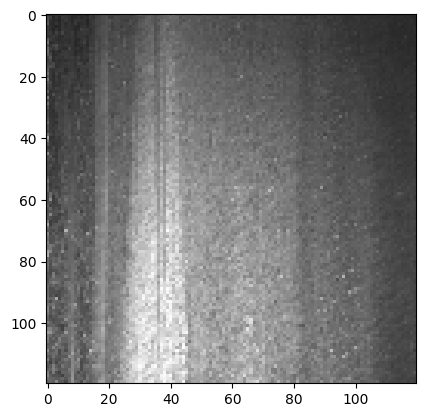

In [20]:
i = 15
plt.imshow(l1[i])

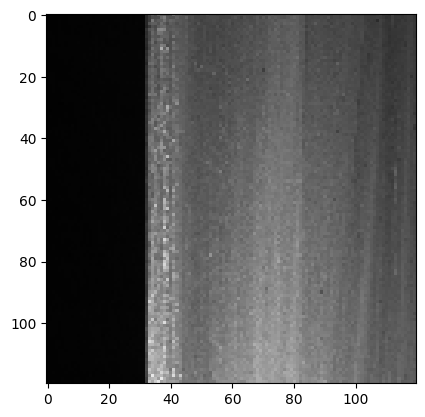

In [21]:
i = 16
plt.imshow(l1[i])

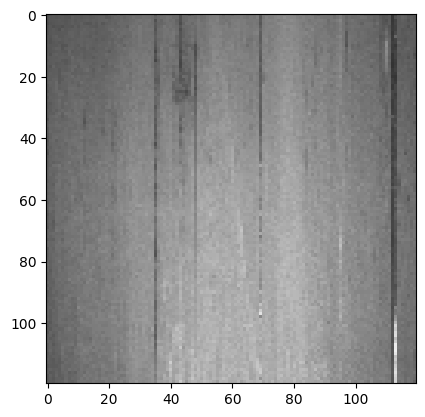

In [22]:
i = 90
plt.imshow(l1[i])

Выполним one-hot кодировку

In [23]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


In [26]:
X.shape

(351, 120, 120, 3)

In [27]:
y.shape

(351,)

# Борьба с дибалансом

для борьбы с дисбалансом выполним случайное сэмплирование

**т.е. выполним аугментацию случайным сэмплированием**

In [28]:
from imblearn.over_sampling import RandomOverSampler # импорт класса из библиотеки, которая используется для работы с несбалансированными данными
reshaped_X = X.reshape(X.shape[0],-1) # входные данные X преобразуются, чтобы каждое изображение было "развернуто" в одномерный массив
oversample = RandomOverSampler(sampling_strategy='not majority') # Создание объекта, который будет использоваться для аугментации данных
X, y  = oversample.fit_resample(reshaped_X , y) #применение аугментации к данным
X = X.reshape(-1,120,120,3) # возврат к исходной форме данных

In [29]:
X.shape

(984, 120, 120, 3)

**Проверка данных на сбалансированность**

In [30]:
y.shape

(984,)

In [31]:
y

array([2, 2, 2, 0, 2, 3, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2,
       1, 2, 2, 2, 3, 2, 3, 2, 2, 0, 3, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 0, 2, 3, 2, 2,
       2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 0, 2, 3, 2, 2, 0, 2, 2, 0, 2,
       0, 0, 2, 3, 0, 1, 0, 2, 2, 2, 2, 3, 2, 3, 0, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 0, 3, 0, 2, 2, 1, 0, 2, 3, 2, 2, 2, 3, 0,
       2, 2, 0, 1, 2, 3, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 3,
       0, 1, 2, 3, 2, 2, 0, 0, 1, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 0, 2, 2, 0, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,

***Посмотрим баланс получившихся данных (984)***

In [35]:
df = pd.DataFrame(data=y, columns=["ClassId"])

In [36]:
df.isnull().sum()

ClassId    0
dtype: int64

ClassId
2    246
0    246
3    246
1    246
Name: count, dtype: int64

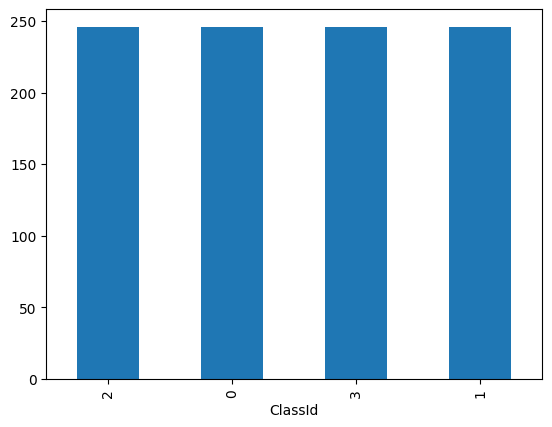

In [37]:
df["ClassId"].value_counts().plot(kind = 'bar')
df["ClassId"].value_counts()

**Получена наглядная картина сбалансированности данных**

**Выполним категоризацию данных классов**

In [38]:

y = to_categorical(y)

In [39]:
y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

разделим на тренировку и валидацию

In [40]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [41]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (787, 120, 120, 3)
x_test размер: (197, 120, 120, 3)
y_train размер: (787, 4)
y_test размер: (197, 4)


# Построение нейронной сети  в 3 слоя и график обучения

### Тест 1

In [42]:
model_1=Sequential()
model_1.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model_1.add(Flatten())
model_1.add(Dense(4,activation="softmax"))

In [43]:
model_1.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [44]:
history = model_1.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
7/7 [==============================] - 10s 1s/step - loss: 10.8642 - accuracy: 0.2922 - val_loss: 10.5712 - val_accuracy: 0.3553
Epoch 2/10
7/7 [==============================] - 7s 1s/step - loss: 6.6862 - accuracy: 0.3520 - val_loss: 2.5300 - val_accuracy: 0.2843
Epoch 3/10
7/7 [==============================] - 7s 925ms/step - loss: 2.6918 - accuracy: 0.4003 - val_loss: 1.3366 - val_accuracy: 0.5838
Epoch 4/10
7/7 [==============================] - 8s 1s/step - loss: 1.0323 - accuracy: 0.6048 - val_loss: 0.7845 - val_accuracy: 0.6599
Epoch 5/10
7/7 [==============================] - 6s 851ms/step - loss: 0.6529 - accuracy: 0.7776 - val_loss: 0.7128 - val_accuracy: 0.7716
Epoch 6/10
7/7 [==============================] - 8s 1s/step - loss: 0.5003 - accuracy: 0.8005 - val_loss: 0.6028 - val_accuracy: 0.7817
Epoch 7/10
7/7 [==============================] - 6s 858ms/step - loss: 0.3770 - accuracy: 0.8844 - val_loss: 0.4818 - val_accuracy: 0.8731
Epoch 8/10
7/7 [=============

<Axes: title={'center': 'Loss curve'}>

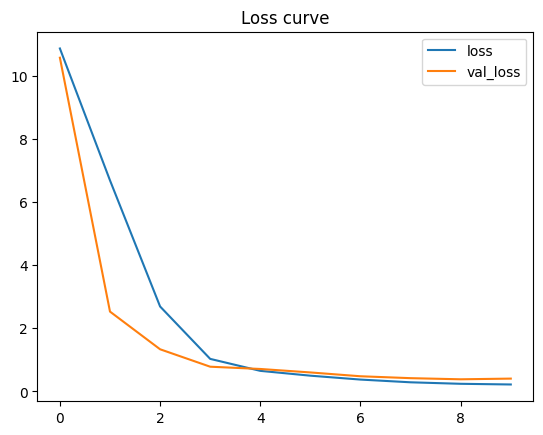

In [45]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

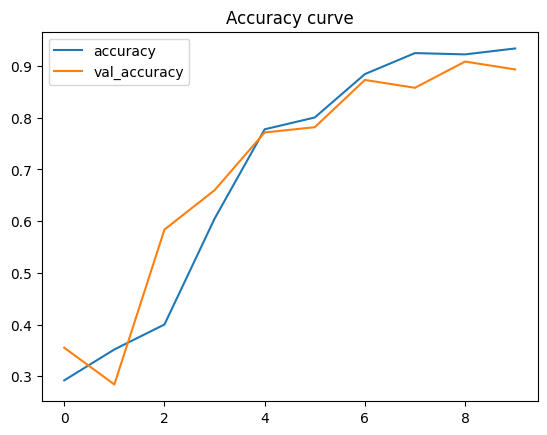

In [46]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети  в 5 слоев

### Тест 2

In [47]:
model_2=Sequential()
model_2.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model_2.add(MaxPooling2D(pool_size=(3,3)))
model_2.add(Flatten())
model_2.add(Dense(256,activation="relu"))
model_2.add(Dense(4,activation="softmax"))


In [48]:
model_2.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [49]:
history = model_2.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
7/7 [==============================] - 12s 2s/step - loss: 5.1597 - accuracy: 0.3139 - val_loss: 1.9741 - val_accuracy: 0.4010
Epoch 2/10
7/7 [==============================] - 11s 2s/step - loss: 1.7732 - accuracy: 0.3888 - val_loss: 1.5879 - val_accuracy: 0.5178
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 1.1034 - accuracy: 0.6036 - val_loss: 0.9866 - val_accuracy: 0.6142
Epoch 4/10
7/7 [==============================] - 12s 2s/step - loss: 0.8502 - accuracy: 0.7128 - val_loss: 0.8756 - val_accuracy: 0.6599
Epoch 5/10
7/7 [==============================] - 11s 2s/step - loss: 0.7036 - accuracy: 0.7637 - val_loss: 0.7361 - val_accuracy: 0.8020
Epoch 6/10
7/7 [==============================] - 11s 2s/step - loss: 0.5802 - accuracy: 0.8196 - val_loss: 0.6303 - val_accuracy: 0.7970
Epoch 7/10
7/7 [==============================] - 10s 2s/step - loss: 0.4756 - accuracy: 0.8628 - val_loss: 0.6080 - val_accuracy: 0.7766
Epoch 8/10
7/7 [===================

<Axes: title={'center': 'Loss curve'}>

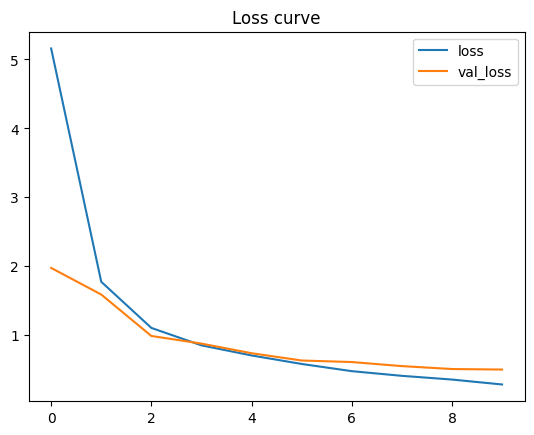

In [50]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

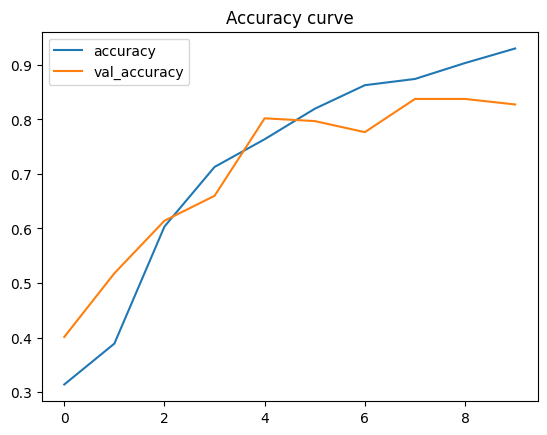

In [51]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети в 13 слоев и обучение

### Тест 3

In [52]:
model_3=Sequential()
model_3.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model_3.add(MaxPooling2D(pool_size=(3,3)))
model_3.add(Conv2D(64,(3,3),activation="relu"))
model_3.add(MaxPooling2D(pool_size=(3,3)))
model_3.add(Conv2D(64,(3,3),activation="relu"))
model_3.add(MaxPooling2D(pool_size=(4,4)))
model_3.add(Flatten())
model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))
model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))
model_3.add(Dense(256,activation="relu"))
model_3.add(Dense(4,activation="softmax"))

In [53]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

Сборка и обучение модели

In [54]:
model_3.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [55]:
history = model_3.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
7/7 [==============================] - 14s 2s/step - loss: 1.3613 - accuracy: 0.3062 - val_loss: 1.3396 - val_accuracy: 0.3553
Epoch 2/10
7/7 [==============================] - 12s 2s/step - loss: 1.3235 - accuracy: 0.3659 - val_loss: 1.2667 - val_accuracy: 0.3706
Epoch 3/10
7/7 [==============================] - 12s 2s/step - loss: 1.2439 - accuracy: 0.4193 - val_loss: 1.1028 - val_accuracy: 0.5990
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 1.1077 - accuracy: 0.4968 - val_loss: 0.9904 - val_accuracy: 0.5330
Epoch 5/10
7/7 [==============================] - 11s 1s/step - loss: 1.0428 - accuracy: 0.4956 - val_loss: 0.9913 - val_accuracy: 0.5635
Epoch 6/10
7/7 [==============================] - 12s 2s/step - loss: 1.0059 - accuracy: 0.5248 - val_loss: 0.9432 - val_accuracy: 0.5635
Epoch 7/10
7/7 [==============================] - 11s 2s/step - loss: 0.9881 - accuracy: 0.5210 - val_loss: 0.9125 - val_accuracy: 0.5533
Epoch 8/10
7/7 [==================

# Анализ результатов обучения

<Axes: title={'center': 'Loss curve'}>

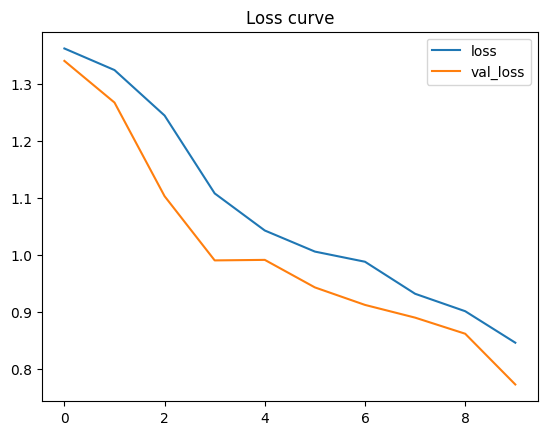

In [56]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

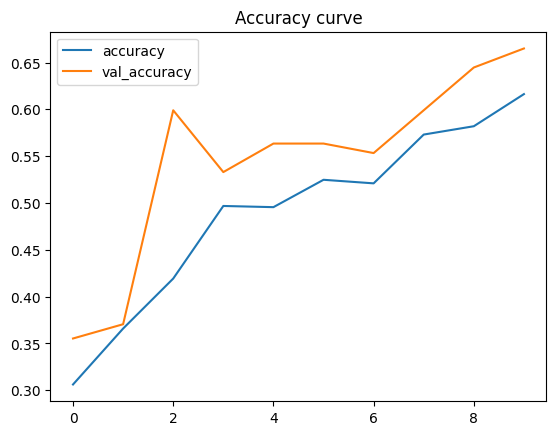

In [57]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [58]:
result = model_3.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

7/7 [==============================] - 1s 172ms/step - loss: 0.7733 - accuracy: 0.6650
[+] Accuracy: 66.50%


In [59]:
result = model_2.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

7/7 [==============================] - 1s 94ms/step - loss: 0.4988 - accuracy: 0.8274
[+] Accuracy: 82.74%


In [60]:
result = model_1.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

7/7 [==============================] - 1s 89ms/step - loss: 0.4076 - accuracy: 0.8934
[+] Accuracy: 89.34%


Модель с тремя слоями показала самые высокие результаты точности: 89%, а также наименьшее количество потерь.

# Архитектура созданной нейронной сети

In [61]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 flatten (Flatten)           (None, 445568)            0         
                                                                 
 dense (Dense)               (None, 4)                 1782276   
                                                                 
Total params: 1783172 (6.80 MB)
Trainable params: 1783172 (6.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 39, 32)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 48672)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               12460288  
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 12462212 (47.54 MB)
Trainable params: 12462212 (47.54 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [63]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 39, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 64)         

# Тестирование на новых примерах

In [136]:
l2[:4]

[3, 3, 3, 1]

In [137]:
x = np.array(l1[:4])
x = x / 255

y = encoder.fit_transform(l2[:4])
y = np.array(y)
y

array([1, 1, 1, 0])

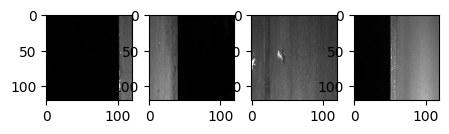

In [142]:
for i in range(4):
    plt.subplot(2,5,i+1)
    plt.imshow(l1[i])
plt.show()

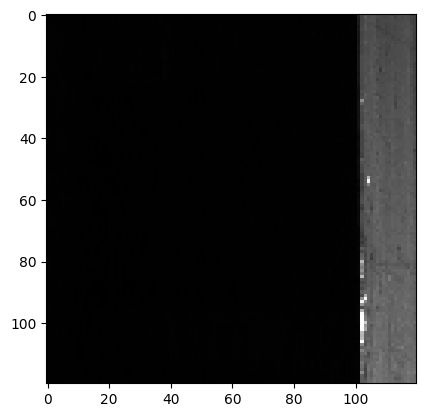

In [114]:
plt.imshow(l1[0]);

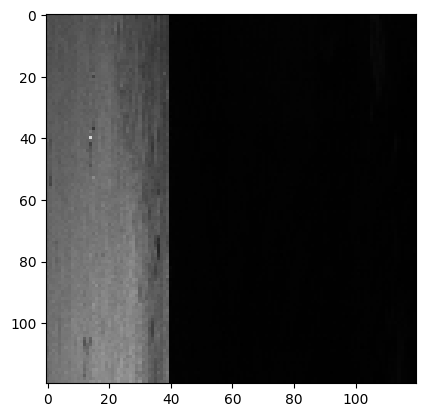

In [76]:
plt.imshow(l1[1]);

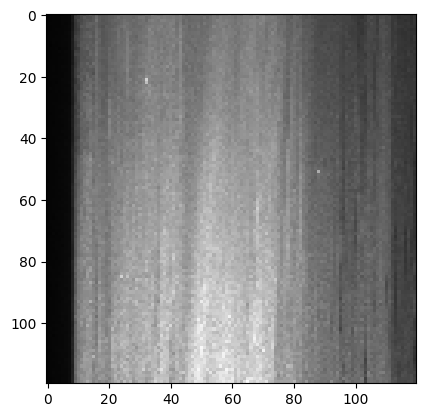

In [149]:
plt.imshow(l1[4]);

In [143]:
y =  to_categorical(y,)
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [144]:

predictions = np.argmax(model_1.predict(X), axis=1)
predictions

1/1 [==============================] - 0s 31ms/step


array([1, 2, 2, 0])

In [145]:
predictions = np.argmax(model_2.predict(X), axis=1)
predictions

1/1 [==============================] - 0s 68ms/step


array([1, 2, 0, 0])

In [146]:
predictions = np.argmax(model_3.predict(X), axis=1)
predictions

1/1 [==============================] - 0s 35ms/step


array([1, 2, 2, 0])

В трёх проведённых экспериментах модель угадала правильный ответ в 50% случаев. ([1, 1, 1, 0])  

In [150]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 flatten (Flatten)           (None, 445568)            0         
                                                                 
 dense (Dense)               (None, 4)                 1782276   
                                                                 
Total params: 1783172 (6.80 MB)
Trainable params: 1783172 (6.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [151]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 39, 32)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 48672)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               12460288  
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 12462212 (47.54 MB)
Trainable params: 12462212 (47.54 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [152]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 39, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 64)         

# описание архитектуры нейронной сети

У нас тут многослойная нейронная сеть с разными типами слоев.

теперь по поводу слоев нейронной сети и их особенностей.

1 слой - Conv2D. Он используется для выполнения двумерной свертки входных данных. Он применяет набор фильтров к входному изображению или карте объектов, перемещая их по входным данным и вычисляя скалярное произведение в каждом месте. Эта операция позволяет слою извлекать объекты и фиксировать пространственные отношения во входных данных. Уровень Conv2D обычно используется в сверточных нейронных сетях (CNN) для таких задач, как классификация изображений, обнаружение объектов и сегментация изображений.

2 слой - MaxPooling2D.  Это  операция понижающей дискретизации, которая уменьшает пространственные размеры (ширину и высоту) входного изображения или карты объектов. Он делит входные данные на непересекающиеся прямоугольники и выводит максимальное значение внутри каждого прямоугольника. Это помогает извлечь наиболее важные функции и снизить вычислительные требования для последующих слоев.

Далее эти слои повторяются еще 2 раза.

7 слой - Flatten. он преобразует входной тензор в одномерный массив, эффективно выравнивая его. Он принимает многомерный входной тензор, например двумерное изображение, и преобразует его в одномерный вектор, который можно использовать в качестве входных данных для полностью связного слоя или любого другого слоя, который ожидает одномерных входных данных.

8 слой - Dense. это полностью связный слой, который соединяет каждый нейрон предыдущего слоя с каждым нейроном текущего слоя. Он выполняет линейную операцию над входными данными, за которой следует функция активации, позволяющая сети изучать сложные закономерности и взаимосвязи в данных. Количество нейронов в плотном слое определяет размерность вывода.

9 cлой - Dropout. это метод регуляризации, используемый для уменьшения переобучения в нейронных сетях. Он случайным образом устанавливает для части входных единиц значение 0 на каждом этапе обучения, что помогает предотвратить слишком большую зависимость сети от конкретных функций или корреляций. Dropout улучшает способность модели к обобщению за счет внесения шума во время обучения и побуждает сеть изучать более надежные и независимые представления.

Далее слои повторяются.

В итоге в данной нейронной сети 12 различных слоев, и 139 780 параметров.